# Introduction

This notebook shows the basics of using xarray to manipulate and plot spatial data.

Copyright (c) 2025-now, Institut des Géosciences de l'Environnement, (IGE, UMR 5001), Grenoble, France.

This software is released under the terms of the so-called BSD 3-clause license. The full text of this license can be found in the LICENSE file or [on the web](https://directory.fsf.org/wiki/License:BSD-3-Clause).

We will work with a dataset containing the 2023 surface-level concentrations of hydrophilic and hydrophobic black carbon aerosol mixing ratios from the Copernicus Atmosphere Monitoring Service (CAMS) global reanalysis dataset (EAC4).

This dataset should be cited as: Inness _et al._, The CAMS reanalysis of atmospheric composition, _Atmospheric Chemistry and Physics_, 19, 3515-3556, 2019, doi: [10.5194/acp-19-3515-2019](https://doi.org/10.5194/acp-19-3515-2019).

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy

# Open the netcdf file and show a summary of its content

In [2]:
filepath = "./data/CAMS_EAC4/surface-black-carbon-2023/data_mlev.nc"

ds = xr.open_dataset(filepath)

print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:      (valid_time: 2920, model_level: 1, latitude: 241,
                  longitude: 480)
Coordinates:
  * valid_time   (valid_time) datetime64[ns] 23kB 2023-01-01 ... 2023-12-31T2...
  * model_level  (model_level) float64 8B 60.0
  * latitude     (latitude) float64 2kB 90.0 89.25 88.5 ... -88.5 -89.25 -90.0
  * longitude    (longitude) float64 4kB 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
Data variables:
    aermr09      (valid_time, model_level, latitude, longitude) float32 1GB ...
    aermr10      (valid_time, model_level, latitude, longitude) float32 1GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-03T10:36 GRIB to CDM+CF via cfgrib-0.9.1...


# Plot a map of one of the file's variables (averaged over the year)

Here we choose to plot the yearly-averaged (year 2023) surface concentrations of hydrophobic black carbon aerosol mixing ratio (variable `aermr10`).

First, we get the values and calculate the time-average:

In [3]:
varname = "aermr10"
values = ds[varname].values[:,0,:,:].mean(axis=0)

Then we create a plot of these time-averaged mixing ratios:

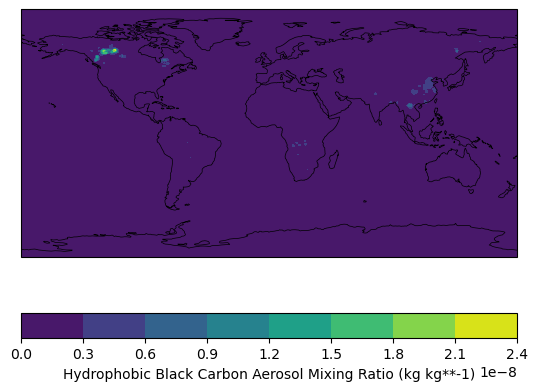

In [4]:
fig = plt.figure()
crs_lonlat = cartopy.crs.PlateCarree()
ax = fig.add_subplot(projection=crs_lonlat)
ax.coastlines(lw=0.5)

plot = ax.contourf(ds["longitude"], ds["latitude"], values)
label = ds[varname].attrs["long_name"] + " (" + ds[varname].attrs["units"] + ")"
cb = plt.colorbar(plot, orientation="horizontal", label=label)

It is quite difficult to see the spatial features with the default linear color scale. Let us use a logarithmic scale instead:

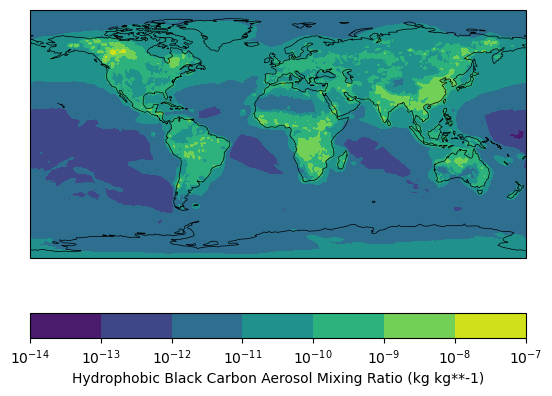

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection=crs_lonlat)
ax.coastlines(lw=0.5)

plot = ax.contourf(ds["longitude"], ds["latitude"], values, locator=mpl.ticker.LogLocator())
cb = plt.colorbar(plot, orientation="horizontal", label=label)

# Calculate and plot a new variable (total black carbon)

We now calculate total black carbon as the sum of hydrophilic black carbon (variable `aermr09`) and hydrophobic black carbon (variable `aermr10`)

In [6]:
varname_philic = "aermr09"
varname_phobic = "aermr10"
varname_total = "total_bc"

# Make sure that the units are the same for the two variables
units = ds[varname_philic].attrs["units"]
if ds[varname_phobic].attrs["units"] != units:
    raise ValueError("Inconsistent units")

# Add a new "total_bc" variable to the dataset
ds = ds.assign({varname_total: ds[varname_philic] + ds[varname_phobic]})

# Add metadata to this new variable
ds[varname_total].attrs["units"] = units
ds[varname_total].attrs["long_name"] = "Total Black Carbon Aerosol Mixing Ratio"

Let us plot the total black carbon mixing ratios that we have just calculated, averaged over the year 2023. Again, we use a logarithmic color scale:

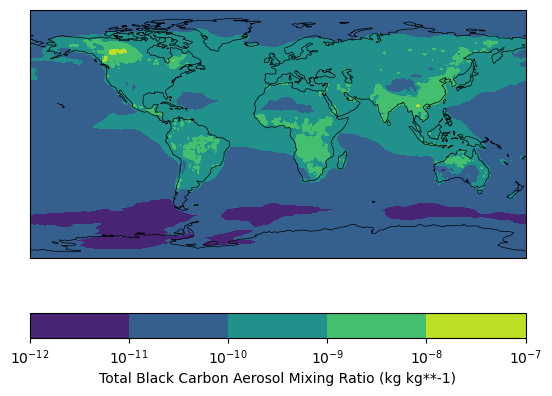

In [7]:
bc = ds[varname_total].values[:,0,:,:].mean(axis=0)

fig = plt.figure()
ax = fig.add_subplot(projection=crs_lonlat)
ax.coastlines(lw=0.5)

plot = ax.contourf(ds["longitude"], ds["latitude"], bc, locator=mpl.ticker.LogLocator())
label = ds[varname_total].attrs["long_name"] + " (" + ds[varname_total].attrs["units"] + ")"
cb = plt.colorbar(plot, orientation="horizontal", label=label)

# Make a plot for a specific region

## The 48 contiguous United States

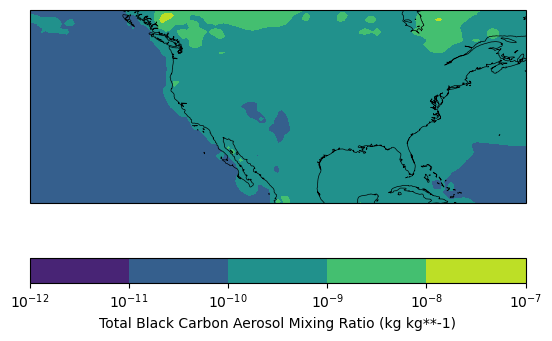

In [8]:
ax.set_xlim(-150, -60)
ax.set_ylim(20, 55)
fig

It looks quite good! Let us try on another region now...

## Greenland

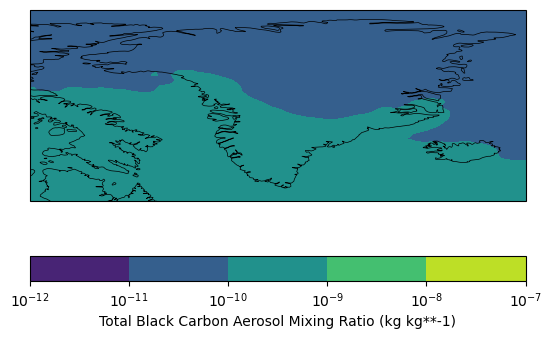

In [9]:
ax.set_xlim(-80, -10)
ax.set_ylim(58, 85)
fig

This map looks a bit weird, doesn't it? Here Greenland looks wider compared to when we see it on a globe. This is because planet Earth is sphere-like and we have to deform maps to be able to plot them on a flat surface.

There are many different methods (called **projections**) to transform (longitude,latitude) coordinates to (x,y) coordinates.

The list of projections available in the cartopy python package can be found [here](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#cartopy-projections).

So far we have been using the **plate carree** projection (see variable `crs_lonlat` above), which treats longitude and latitude as simple x and y coordinates, respectively.

A better choice for Greenland is the **North polar stereographic** projection (see example below).

There exists a registry of "standard" projections, the **EPSG registry**, where each projection is referenced by an ID code. You can use [this website](https://epsg.io/) to see the specifications of a given projection. Here we will use [EPSG:3413 (NSIDC Sea Ice Polar Stereographic North)](https://epsg.io/3413).

Note that:
- we define the projection we want to use for the map when creating the subplot with `add_subplot`.
- we specify the projection actually used by the data when plotting data (`contourf`, `text`, ...).
- with this information, matplotlib and cartopy re-project data behind the scene as needed.

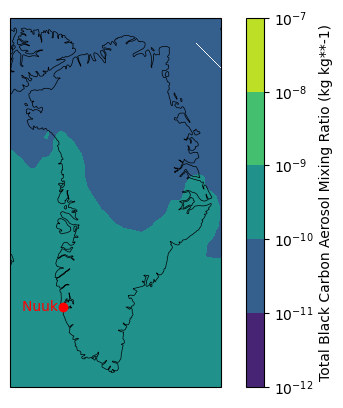

In [10]:
# Define the CRS corresponding to EPSG:3413
crs_stereo = cartopy.crs.NorthPolarStereo(
    central_longitude=-45,
    true_scale_latitude=70
)

# Prepare the map
fig = plt.figure()
ax = fig.add_subplot(projection=crs_stereo)
ax.coastlines(lw=0.5)

# Plot the data and add the colorbar
plot = ax.contourf(
    ds["longitude"], ds["latitude"], bc,
    transform=crs_lonlat,
    locator=mpl.ticker.LogLocator()
)
cb = plt.colorbar(plot, orientation="vertical", label=label)

# Add a dot showing Greenland's capital city (Nuuk)
lon_nuuk = -51.737
lat_nuuk = 64.174
ax.plot([lon_nuuk], [lat_nuuk], "ro", transform=crs_lonlat)
ax.text(lon_nuuk, lat_nuuk, "Nuuk ", transform=crs_lonlat,
        color="r", va="center", ha="right")

# Center the map on Greenland
xmin, xmax = ax.set_xlim(-750000, 920000)
ymin, ymax = ax.set_ylim(-3460000, -533000)

# Create a new dataset

## Example 1: create a new dataset containing our newly calculated total black carbon variable

In [11]:
ds_total_bc = xr.Dataset(
    data_vars=dict(
        black_carbon=(["time", "lat", "lon"], ds[varname_total].values[:,0,:,:]),
    ),
    coords=dict(
        lon=ds["longitude"].values,
        lat=ds["latitude"].values,
        time=ds["valid_time"].values,
    )
)

print(ds_total_bc)

<xarray.Dataset> Size: 1GB
Dimensions:       (time: 2920, lat: 241, lon: 480)
Coordinates:
  * lon           (lon) float64 4kB 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
  * lat           (lat) float64 2kB 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time          (time) datetime64[ns] 23kB 2023-01-01 ... 2023-12-31T21:00:00
Data variables:
    black_carbon  (time, lat, lon) float32 1GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0


## Example 2: create a geographical subset of the original dataset

In [12]:
lon_min = -10
lon_max = 40
lat_min = 30
lat_max = 60

# Be careful, in our original dataset, latitudes are specified in decreasing order
ds_subset = ds.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

print(ds_subset)

<xarray.Dataset> Size: 78MB
Dimensions:      (valid_time: 2920, model_level: 1, latitude: 41, longitude: 54)
Coordinates:
  * valid_time   (valid_time) datetime64[ns] 23kB 2023-01-01 ... 2023-12-31T2...
  * model_level  (model_level) float64 8B 60.0
  * latitude     (latitude) float64 328B 60.0 59.25 58.5 ... 31.5 30.75 30.0
  * longitude    (longitude) float64 432B 0.0 0.75 1.5 2.25 ... 38.25 39.0 39.75
Data variables:
    aermr09      (valid_time, model_level, latitude, longitude) float32 26MB ...
    aermr10      (valid_time, model_level, latitude, longitude) float32 26MB ...
    total_bc     (valid_time, model_level, latitude, longitude) float32 26MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-03T10:36 GRIB to CDM+CF